In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
def DMD(X,Xprime,r):
    # X: [x0, x1 ... xn-1]
    # Xprime: [x1, x2, ... xn]
    # r: how many modes to keep. r <= rank(Sigma), r<=n
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)

    # sort modes based on their contribution ('amplitude')
    idx = np.argsort(np.abs(b))
    idx = np.flip(idx)
    b = b[idx]
    Lambda = np.diag(np.diag(Lambda)[idx])
    Phi = Phi[:,idx]
    
    return Phi, Lambda, b

In [3]:
#=================== downsampled data ======================
filename = "./PIV4_downsampled_by8.h5" # .h5 file of data
hf = h5py.File(filename,'r')
z = np.array(hf.get('z'))
y = np.array(hf.get('y'))
vy = np.array(hf.get('vy'))
vz = np.array(hf.get('vz'))
hf.close()
print("Finished loading data.")
# print(vy.shape)
[nt,nz,ny] = vz.shape

# remove mean
# vy = vy - np.mean(vy,0)
# vz = vz - np.mean(vz,0)

vy = np.transpose(vy,[2,1,0])
vz = np.transpose(vz,[2,1,0]) #(ny,nz,nt)


dt = 1*(1./720)
print(vy.shape)

Finished loading data.
(21, 24, 2732)


In [ ]:
#=================== autoencoder data =====================
filename = '../../../Scripts/PIV/Autoencoder/MD_2__2022_02_02__16_51_24/results.h5'
hf = h5py.File(filename,'r')
decomp_test = np.array(hf.get('modes_test'))
hf.close()
print("Finished loading data.")
[latent_dim,nt,ny,nz,nu] = decomp_test.shape
print(latent_dim,nt,ny,nz,nu)

WhichDecoder = 0
vy = decomp_test[WhichDecoder,:,:,:,0].astype('float64')
vy = np.transpose(vy,[1,2,0])
vz = decomp_test[WhichDecoder,:,:,:,1].astype('float64')
vz = np.transpose(vz,[1,2,0]) # (ny,nz,nt)
dt = 1*(1./720)

In [5]:
#==================== prepare data =========================
# build matrix
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
X = np.reshape(X,(2*nz*ny,nt)) # [2*ny*nz,nt]
# X = X[:,::1]
# dt = 1*dt
print("Snapshot matrix, shape: ",X.shape)

Snapshot matrix, shape:  (1008, 2732)


In [15]:
#================================ DMD ========================
Phi,Lambda,b = DMD(X[:,:-1],X[:,1:],1008) # mode, frequency and damping, contribution = DMD(X,X',how many modes)
print(Phi.shape,Lambda.shape,b.shape)

(1008, 1008) (1008, 1008) (1008,)


In [ ]:
#======================== Plot Mode =========================
mode = np.reshape(Phi,(2*ny,nz,-1))
mode_z = mode[:ny,:,:].real # X was built vstack(vz,vy)
mode_y = mode[ny:,:,:].real # has shape [ny,nz,modes]

whichmode = 0
whichvelocity = 'v'
plt.figure()
if whichvelocity == 'w':
    plt.imshow(mode_z[:,:,whichmode],'jet')
else:
    plt.imshow(mode_y[:,:,whichmode],'jet')
# plt.title('decoder '+str(WhichDecoder+1))
plt.show()
print(np.diag(Lambda)[whichmode])

plt.suptitle("DMD modes in decoder " + str(WhichDecoder+1) + ", " + whichvelocity)
# plt.suptitle("DMD modes "+ whichvelocity)
lam = np.diag(Lambda)
lam_r = np.abs(lam)
lam_f = np.angle(lam)/(2*np.pi)/dt
for i in range(9):
    title = str(i+1)+', a='+str(np.around(lam_r[i],decimals=2))+" f="+str(np.around(lam_f[i],1))
    # title = str(i+1)+',λ='+str(np.around(np.diag(Lambda)[i],decimals=3))
    ax = plt.subplot(3,3,i+1,title=title,xticks=[],yticks=[])
    if whichvelocity == 'w': # Q was built [vz,vy]
        pltV = mode_z[:,:,i]
    elif whichvelocity == 'v':
        pltV = mode_y[:,:,i]
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
plt.show()

In [ ]:
print(np.abs(np.diag(Lambda)))

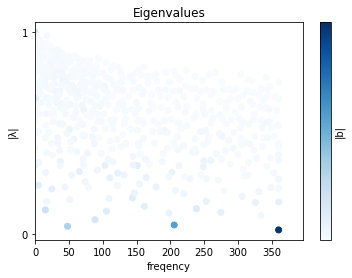

[ 360.         -205.65737674  205.65737674 ... -313.61625807 -347.69663619
  347.69663619]
[1.38260783e+03 7.85284077e+02 7.85284077e+02 ... 3.99773028e-01
 3.32153908e-01 3.32153908e-01]


In [12]:
# eigenvalue plot, temporal behaviour
lam = np.diag(Lambda)
lam_r = np.abs(lam)
lam_f = np.angle(lam)/(2*np.pi)/dt
# max_fq = max(lam_f)
b_r = np.abs(b)
plt.figure()
# plt.scatter(lam_f,lam_r)
plt.scatter(lam_f,lam_r,c=b_r,cmap='Blues',vmin=0,vmax=max(b_r))
plt.colorbar(label='|b|',ticks=[])
plt.xlabel('freqency')
plt.ylabel('|λ|')
plt.title('Eigenvalues')
plt.yticks([0,1])
# plt.hlines(1,0,360,colors='k',linestyles='dotted')
plt.xlim(left=0)
plt.show()
print(lam_f)
print(b_r)

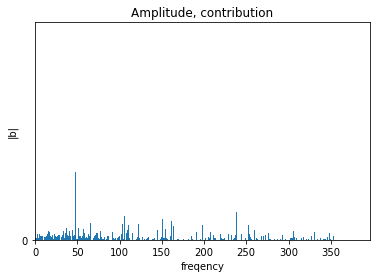

In [14]:
# amplitude
idx_freq = np.argsort(lam_f)
lam_f_sorted = lam_f[idx_freq]

b_r = np.abs(b)
b_r_sorted = b_r[idx_freq]
max_fq = max(lam_f)
plt.figure()
# plt.plot(lam_f_sorted,b_r_sorted)
plt.bar(lam_f_sorted,b_r_sorted,width=700/1008)
plt.xlabel('freqency')
plt.ylabel('|b|')
plt.title('Amplitude, contribution')
# plt.xticks([])
plt.xlim(left=0)
plt.yticks([0])
plt.show()